In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import scipy.io as sio
from scipy.signal import resample
import os

import numpy as np
import random

from multilabel_rbm import RBM as MRBM
from rbm import RBM 
from class_rbm import ClassRBM

from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.signal import correlate



In [3]:
experiments = os.listdir('../datasets/sample_experiments/')

In [4]:
scaler = preprocessing.MinMaxScaler(feature_range=[-1,1])

In [5]:
all_data = []

In [8]:
experiment_samples = {}

for experiment in experiments:
    data = sio.loadmat('../datasets/sample_experiments/' + experiment)
    data = data['Data_dq'][0][0][1][0][0][0]
    downsample_data = []
    for i in range(0,data.shape[0],500):
        downsample_data.append(data[i])
    downsample_data = np.asarray(downsample_data)
    print(data.shape, downsample_data.shape)
#     all_data += list(downsample_data)
    experiment_samples[experiment[:-4]] = scaler.transform(downsample_data)

((3492633, 7), (6986, 7))
((1090600, 7), (2182, 7))
((3835275, 7), (7671, 7))
((2817307, 7), (5635, 7))
((1637459, 7), (3275, 7))
((2209425, 7), (4419, 7))
((2488471, 7), (4977, 7))
((3458049, 7), (6917, 7))
((13729174, 7), (27459, 7))
((3867079, 7), (7735, 7))
((1636972, 7), (3274, 7))
((1967146, 7), (3935, 7))
((3410960, 7), (6822, 7))
((3759685, 7), (7520, 7))
((1305561, 7), (2612, 7))
((2338492, 7), (4677, 7))
((3691522, 7), (7384, 7))
((3900352, 7), (7801, 7))


In [7]:
# all_data = np.asarray(all_data)
# print (all_data.shape)
# scaler.fit(all_data)

(121281, 7)


MinMaxScaler(copy=True, feature_range=[-1, 1])

In [88]:
train = []
test = []

stride = 10
window = 30
for exp in experiment_samples.keys()[:14]:
    experiment_sample = experiment_samples[exp]
    
    samples = []
    for i in range(0, experiment_sample.shape[0], stride):
        if experiment_sample[i:i+window,:].shape[0] == window:
            samples.append(experiment_sample[i:i+window,:])
        
    random.shuffle(samples)
    train += samples
    
for exp in experiment_samples.keys()[14:]:
    print (exp)
    experiment_sample = experiment_samples[exp]
    
    samples = []
    for i in range(0, experiment_sample.shape[0], stride):
        if experiment_sample[i:i+window,:].shape[0] == window:
            samples.append(experiment_sample[i:i+window,:])
        
    random.shuffle(samples)
    test += samples
    
train = np.asarray(train)
test = np.asarray(test)

exp13
exp12
exp11
exp10


In [89]:
print train.shape, test.shape
print train[:,:,0].max(), train[:,:,1].max(), train[:,:,5].max(), train[:,:,3].max(), train[:,:,4].max(), train[:,:,6].max()
print train[:,:,0].min(), train[:,:,1].min(), train[:,:,5].min(), train[:,:,3].min(), train[:,:,4].min(), train[:,:,6].min()

(10163, 30, 7) (1921, 30, 7)
1.0 1.0 1.0 1.0 1.0 1.0
-1.0 -1.0 -0.9999607920205232 -1.0 -0.8092929197694757 -0.7311461920148765


In [90]:
class FFNet(nn.Module):
    def __init__(self, input_dim):
        super(FFNet, self).__init__()
        self.linear1 = nn.Linear(input_dim, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, input_dim/3)

    def forward(self, seq):
        x = seq.view(seq.size()[0], -1)
        out = F.tanh(self.linear1(x))
        out = F.tanh(self.linear2(out))
#         out = self.linear3(out)
        out = self.linear4(out)
        #print (out.size())
        #base_out = out.view(seq.size()[0], seq.size()[1], seq.size()[2])
        return out

In [76]:
class LSTMNet(nn.Module):

    def __init__(self, hidden_dim, layer1_dim, layer2_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(3, hidden_dim, batch_first=True) 
        self.linear1 = nn.Linear(hidden_dim, layer1_dim)
        self.linear2 = nn.Linear(layer1_dim, 1)
        self.linear3 = nn.Linear(layer1_dim, 1)
        
        self.linear4 = nn.Linear(layer1_dim, layer2_dim)
        self.linear5 = nn.Linear(layer2_dim, 1)

    def forward(self, seq):
        lstm_out = self.lstm(seq)[0]
#         print (lstm_out.size())
        tmp1 = F.tanh(self.linear1(lstm_out))
#         print (lstm_out.size())
        _out1 = self.linear2(tmp1)
        _out2 = self.linear3(tmp1)
        
        _out3 = self.linear4(tmp1)
        _out3 = self.linear5(_out3)
#         print (_out.size())
        base_out1 = _out1.view(-1, 60)
        base_out2 = _out2.view(-1, 60)
        base_out3 = _out3.view(-1, 60)
#         print (base_out.size())
        return base_out1, base_out2, base_out3

In [107]:
# model = LSTMNet(128,300,150).cuda()
model = FFNet(30*3).cuda()

In [108]:
loss_function = nn.MSELoss()
lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr)

In [109]:
for epoch in range(500):
    train = np.random.permutation(train)
    epoch_loss = 0
    for i in range(0, train.shape[0], 256):
        inp = np.concatenate((train[i:i+256, :, 0:2], train[i:i+256, :, 5:6]), axis=2)
        #out_true = np.concatenate((train[i:i+256, :, 3:5], train[i:i+256, :, 6:]), axis=2)
        out_true = train[i:i+256, :, 6]
        inp = Variable(torch.from_numpy(inp).type(torch.FloatTensor).cuda())
        out_true = Variable(torch.from_numpy(out_true).type(torch.FloatTensor).cuda())
        model.zero_grad()
        out_pred = model(inp)
        loss = loss_function(out_pred, out_true)
        loss.backward()
        optimizer.step()

        #print (loss.data[0])
        epoch_loss += loss.data[0]

    test_loss = 0
    for i in range(0, test.shape[0], 256):
        inp = np.concatenate((test[i:i+256, :, 0:2], test[i:i+256, :, 5:6]), axis=2)
        #out_true = np.concatenate((test[i:i+256, :, 3:5], test[i:i+256, :, 6:]), axis=2)
        out_true = test[i:i+256, :, 6]
        out_true = Variable(torch.from_numpy(out_true).type(torch.FloatTensor).cuda())
        inp = Variable(torch.from_numpy(inp).type(torch.FloatTensor).cuda())
        out_pred = model(inp)
        loss = loss_function(out_pred, out_true)

        test_loss += loss.data[0]
    
   # print ("Epoch " + str(epoch) +  ": Train loss = " + str(epoch_loss.item()) + ", Test loss = " + str(test_loss.item()))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [14]:
for epoch in range(200):
    train = np.random.permutation(train)
    epoch_loss = 0
    for i in range(0, train.shape[0], 256):
        inp = np.concatenate((train[i:i+256, :, 0:2], train[i:i+256, :, 5:6]), axis=2)
        out_true = np.concatenate((train[i:i+256, :, 3:5], train[i:i+256, :, 6:]), axis=2)
#         out_true = train[i:i+256, :, 0]
        inp = Variable(torch.from_numpy(inp).type(torch.FloatTensor).cuda())
        out_true = Variable(torch.from_numpy(out_true).type(torch.FloatTensor).cuda())
        model.zero_grad()
        out_pred1, out_pred2, out_pred3 = model(inp)
        loss = loss_function(out_pred1, out_true[:, :, 0]) + loss_function(out_pred2, out_true[:, :, 1]) + loss_function(out_pred3, out_true[:, :, 2])
        loss.backward()
        optimizer.step()
        
        #print (loss.data[0])
        epoch_loss += loss.data[0]
    
    test_loss = 0
    for i in range(0, test.shape[0], 256):
        inp = np.concatenate((test[i:i+256, :, 0:2], test[i:i+256, :, 5:6]), axis=2)
        out_true = np.concatenate((test[i:i+256, :, 3:5], test[i:i+256, :, 6:]), axis=2)
#         out_true = test[i:i+256, :, 0]
        out_true = Variable(torch.from_numpy(out_true).type(torch.FloatTensor).cuda())
        inp = Variable(torch.from_numpy(inp).type(torch.FloatTensor).cuda())
        out_pred1, out_pred2, out_pred3 = model(inp)
        loss = loss_function(out_pred1, out_true[:, :, 0]) + loss_function(out_pred2, out_true[:, :, 1]) + loss_function(out_pred3, out_true[:, :, 2])
        
        test_loss += loss.data[0]
        
    print ("Epoch " + str(epoch) +  ": Train loss = " + str(epoch_loss.item()) + ", Test loss = " + str(test_loss.item()))

ValueError: too many values to unpack

(6957, (6986, 7))


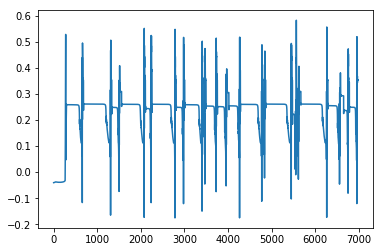

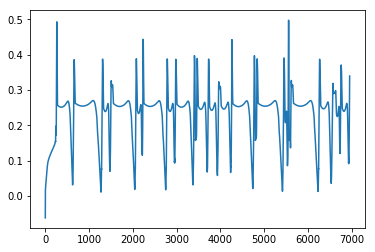

In [110]:
pred_curr1 = []
pred_curr2 = []
pred_torque = []
for i in range(0, experiment_samples['exp13'].shape[0], 1):
    inp = np.concatenate((experiment_samples['exp13'][i:i+window, 0:2], experiment_samples['exp13'][i:i+window, 5:6]), axis=1)
    if inp.shape[0] == window:
        inp = np.asarray([inp])
        inp = Variable(torch.from_numpy(inp).type(torch.FloatTensor).cuda())
        out_pred1 = model(inp)
#         print (out_pred.size())
        out_pred1 = out_pred1.data.cpu().numpy()
#         out_pred2 = out_pred2.data.cpu().numpy()
#         out_pred3 = out_pred3.data.cpu().numpy()
        
        pred_curr1 += list(out_pred1[:, 10])
#         pred_curr2 += list(out_pred2[:, 0])
#         pred_torque += list(out_pred3[:, 0])
    

print (len(pred_curr1), experiment_samples['exp13'].shape)
plt.plot(experiment_samples['exp13'][:,6])
plt.show()
plt.plot(pred_curr1)
plt.show()
# plt.plot(experiment_samples['exp10'][:,4])
# plt.show()
# plt.plot(pred_curr2)
# plt.show()
# plt.plot(experiment_samples['exp10'][:,6])
# plt.show()
# plt.plot(pred_torque)
# plt.show()
# plt.plot(correlate(pred_curr1, experiment_samples['exp10'][:,3]))
# plt.show()
# plt.plot(experiment_samples['exp10'][:-99,3] - np.asarray(pred_curr1))
# plt.show()

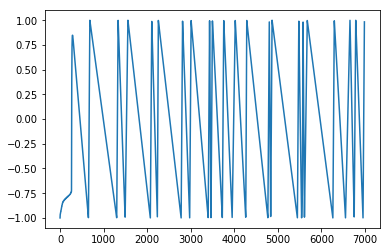

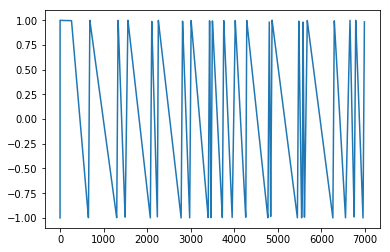

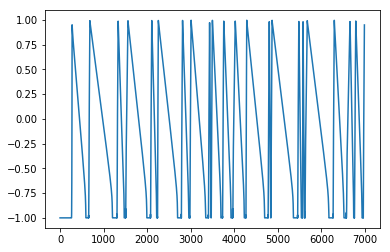

In [54]:
plt.plot(experiment_samples['exp13'][:,1])
plt.show()
plt.plot(experiment_samples['exp13'][:,2])
plt.show()
plt.plot(experiment_samples['exp13'][:,5])
plt.show()

In [361]:
mrbm = ClassRBM(180, 180, 1024, 20, 0.1)
loss_function = nn.L1Loss()

In [363]:
for epoch in range(10):
    train = np.random.permutation(train)
    epoch_loss = 0
    for i in range(0, train.shape[0], 256):
        inp = np.concatenate((train[i:i+256, :, 0:2], train[i:i+256, :, 5:6]), axis=2)
        out = np.concatenate((train[i:i+256, :, 3:5], train[i:i+256, :, 6:]), axis=2)
        inp = Variable(torch.from_numpy(inp).type(torch.FloatTensor).cuda())
        out = Variable(torch.from_numpy(out).type(torch.FloatTensor).cuda())
        
        inp = inp.view(inp.size()[0], inp.size()[1] * inp.size()[2])
        out = out.view(out.size()[0], out.size()[1] * out.size()[2])
        
        inp_loss, out_loss = mrbm.contrastive_divergence(inp, out)
        
        loss = loss_function(out, inp)
        
        #print (loss.data[0])
        epoch_loss += loss.data[0]
    
    test_loss = 0
    for i in range(0, test.shape[0], 256):
        inp = np.concatenate((test[i:i+256, :, 0:2], test[i:i+256, :, 5:6]), axis=2)
        out = np.concatenate((test[i:i+256, :, 3:5], test[i:i+256, :, 6:]), axis=2)
        inp = Variable(torch.from_numpy(inp).type(torch.FloatTensor).cuda())
        
        inp = inp.view(inp.size()[0], inp.size()[1] * inp.size()[2])

        out = mrbm.predict(inp)
        loss = loss_function(out, inp)
        
        test_loss += loss.data[0]
        
    print ("Epoch " + str(epoch) +  ": Train loss = " + str(epoch_loss.item()) + ", Test loss = " + str(test_loss.item()))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0: Train loss = 40.4509544373, Test loss = 5.70673894882
Epoch 1: Train loss = 40.4497718811, Test loss = 5.71215677261
Epoch 2: Train loss = 40.4439888, Test loss = 5.71632575989
Epoch 3: Train loss = 40.4473152161, Test loss = 5.72128391266
Epoch 4: Train loss = 40.4362831116, Test loss = 5.79057693481
Epoch 5: Train loss = 40.4385375977, Test loss = 5.77456045151
Epoch 6: Train loss = 40.4438438416, Test loss = 5.7316327095
Epoch 7: Train loss = 40.4475326538, Test loss = 5.70303583145
Epoch 8: Train loss = 40.4408035278, Test loss = 5.70522069931
Epoch 9: Train loss = 40.441532135, Test loss = 5.73900651932
